In [1]:
%matplotlib inline


# Decoding sensor space data with Generalization Across Time

Authors: Jean-Remi King, Alexandre Gramfort, Denis Engemann

This example runs the analysis computed in:

Jean-Remi King, Alexandre Gramfort, Aaron Schurger, Lionel Naccache
and Stanislas Dehaene, "Two distinct dynamic modes subtend the detection of
unexpected sounds", PLOS ONE, 2013,
http://www.ncbi.nlm.nih.gov/pubmed/24475052

The idea is to learn at one time instant and assess if the decoder
can predict accurately over time.


In [15]:
import mne
from mne.datasets import spm_face
from mne.decoding import GeneralizationAcrossTime

# Preprocess data
data_path = spm_face.data_path()
# Load and filter data, set up epochs
raw_fname = data_path + '/MEG/spm/SPM_CTF_MEG_example_faces%d_3D.ds'

raw = mne.io.read_raw_ctf(raw_fname % 1, preload=True)  # Take first run

picks = mne.pick_types(raw.info, meg=True, exclude='bads')
raw.filter(1., 45, method='iir')

<RawCTF  |  SPM_CTF_MEG_example_faces1_3D.meg4, n_channels x n_times : 340 x 324474 (676.0 sec), ~842.5 MB, data loaded>

In [16]:
events = mne.find_events(raw, stim_channel='UPPT001')
event_id = {"faces": 1, "scrambled": 2}
tmin, tmax = -0.1, 0.5
baseline = (None, 0.)
baseline = None

decim = 4  # decimate to make the example faster to run
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, preload=True,
                    reject=dict(mag=1.5e-12), decim=decim, verbose=False)

epochs

<Epochs  |  n_events : 166 (all good), tmin : -0.1 (s), tmax : 0.5 (s), baseline : None, ~28.8 MB, data loaded,
 'faces': 83, 'scrambled': 83>

maximum AUC score: 0.766093474427


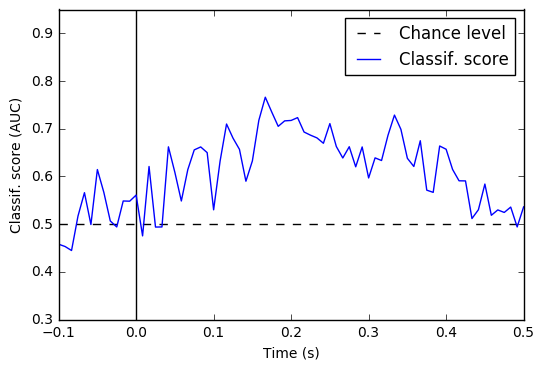

In [17]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

from mne.decoding import TimeDecoding

# make response vector
y = np.zeros(len(epochs.events), dtype=int)
y[epochs.events[:, 2] == 2] = 1

cv = StratifiedKFold() # do a stratified cross-validation
td = TimeDecoding(cv=cv, scorer='roc_auc', n_jobs=1)
# Fit, score, and plot
td.fit(epochs, y=y)
scores = td.score(epochs)
print('maximum AUC score:', max(scores))
td.plot(ymin=0.3, ymax=0.95);

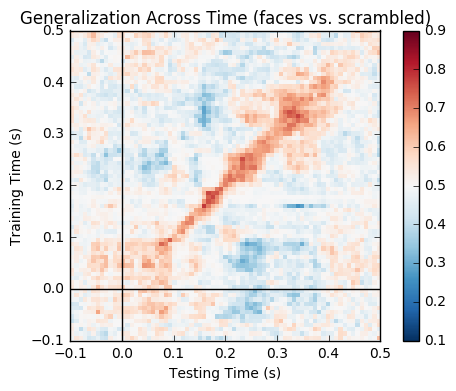

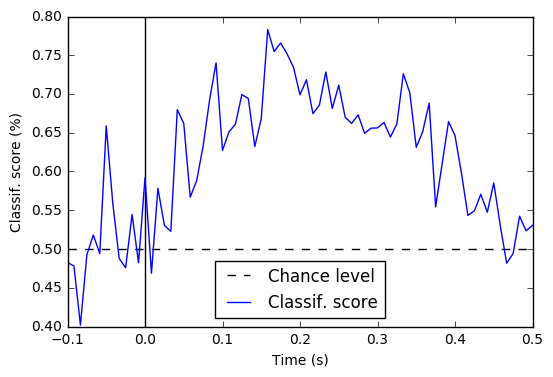

In [18]:
# Define decoder. The decision function is employed to use cross-validation
gat = GeneralizationAcrossTime(predict_mode='cross-validation', n_jobs=1)

# fit and score
gat.fit(epochs)
gat.score(epochs)
gat.plot(vmin=0.1, vmax=0.9,
         title="Generalization Across Time (faces vs. scrambled)")
gat.plot_diagonal();  # plot decoding across time (correspond to GAT diagonal)